In [ ]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
import time

In [ ]:
# Funcția pentru a încărca imaginile
# Fiecare subfolder din folderul principal conține imagini asociate unei clase
def load_images_from_folder(folder, target_shape=None):
    images = [] # Lista pentru stocarea imaginilor
    labels = [] # Lista pentru stocarea etichetelor asociate
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                if filename.endswith(('.jpeg', '.jpg', '.png')): # Verificăm extensia fișierului
                    img = cv2.imread(os.path.join(subfolder_path, filename))
                    if img is not None:
                        if target_shape is not None: # Redimensionăm imaginea dacă este necesar
                            img = cv2.resize(img, target_shape)
                        images.append(img) # Adăugăm imaginea la listă
                        labels.append(subfolder) # Adăugăm eticheta (numele subfolderului)
    return images, labels

In [ ]:
# Funcție pentru a extrage histograma de culori dintr-o imagine
def extract_color_histogram(image, bins=(8, 8, 8)):
    # Calculăm histograma pentru canalele BGR și normalizăm rezultatul
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten() # Aplatizăm matricea într-un vector
    return hist

In [ ]:
# Funcția pentru a extrage caracteristicile de textură folosind GLCM
def extract_texture_features(image):
    # Convertim imaginea în gri pentru calculul GLCM
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Calculăm matricea de coocurență a nivelurilor de gri (GLCM)
    glcm = graycomatrix(gray_image, distances=[1, 2], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)
    # Calculăm proprietățile texturale bazate pe GLCM
    contrast = graycoprops(glcm, 'contrast').mean()
    dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    return [contrast, dissimilarity, homogeneity, energy, correlation]

In [ ]:
# Funcție pentru extragerea caracteristicilor combinate (textură + culori)
def extract_combined_features(image):
    # Extragem caracteristicile de textură (GLCM) și histogramă de culori din imagine
    # la return vom avea un vector de caracteristici combinat.

    texture_features = extract_texture_features(image)  # Caracteristici GLCM
    color_histogram = extract_color_histogram(image)    # Histogramă de culori
    return np.concatenate([texture_features, color_histogram])


In [ ]:
# Setăm căile către date
train_folder = '/content/drive/MyDrive/Colab Notebooks/dataset_tema/houses'
test_folder = '/content/drive/MyDrive/Colab Notebooks/dataset_tema/h_test'


# Încărcăm imaginile de antrenament și testare
train_images, train_labels = load_images_from_folder(train_folder, target_shape=(128, 128))
test_images, test_labels = load_images_from_folder(test_folder, target_shape=(128, 128))


In [ ]:
# Extragem caracteristicile combinate (textură + culoare) pentru antrenament și test
train_features = [extract_combined_features(image) for image in train_images]
test_features = [extract_combined_features(image) for image in test_images]

# Creăm o corelație între etichetele string și indicii numerici
unique_labels = sorted(set(train_labels)) # Obținem etichetele unice sortate
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# Convertim etichetele din string în indici numerici
y_train = np.array([label_to_index[label] for label in train_labels])
y_test = np.array([label_to_index[label] for label in test_labels])

# Împărțim setul de antrenament în seturi de antrenare și validare
X_train, X_val, y_train, y_val, X_train_images, X_val_images = train_test_split(
    train_features, y_train, train_images, test_size=0.2, stratify=y_train, random_state=45,
)

In [ ]:
# Standardizăm caracteristicile (scalare)
scaler = StandardScaler()

# Calculăm media și deviația standard pe setul de antrenament
X_train = scaler.fit_transform(X_train)

# Aplicăm scalarea pe setul de validare și pe cel de test
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_features)

In [ ]:
# Antrenăm modelul SVM cu kernel polinomial
svm_model = SVC(kernel='poly', C=1250, gamma='scale', random_state=45)

svm_model.fit(X_train, y_train) # Antrenăm modelul pe setul de antrenament


SVC(C=1250, kernel='poly', random_state=45)

In [ ]:
# Validăm modelul pe setul de validare
y_val_pred = svm_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Acuratețea pe setul de validare este: {val_accuracy * 100:.2f}%")

# Afișăm n imagini din setul de validare cu predicții
print("Primele n de imagini din setul de validare:")
for i in range(len(X_val)):
    #print(f"Prezis: {y_val_pred[i]}")
    label = index_to_label[y_val_pred[i]]
    true_label = index_to_label[y_val[i]]
    plt.figure()
    plt.imshow(cv2.cvtColor(X_val_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Adevărat: {true_label} / Prezis: {label}")
    plt.axis('off')
    plt.show()


Acuratețea pe setul de validare este: 80.48%


In [ ]:
# Clasificăm pe setul de test
y_test_pred = svm_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Acuratețea pe setul de test este: {test_accuracy * 100:.2f}%")

# Afișăm n imagini din setul de testare cu predicții
for i in range(len(test_images)):
    label = index_to_label[y_test_pred[i]]
    true_label = index_to_label[y_test[i]]
    plt.figure()
    plt.imshow(cv2.cvtColor(test_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Adevărat: {true_label} / Prezis: {label}")
    plt.axis('off')
    plt.show()

Acuratețea pe setul de test este: 81.21%


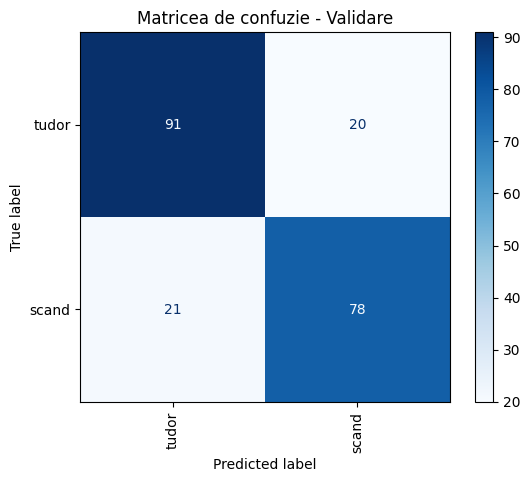

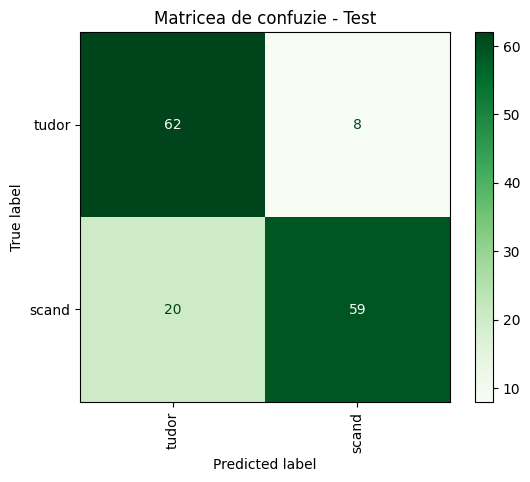

In [ ]:
# Calculăm matricea de confuzie pentru setul de validare
conf_matrix_val = np.flip(confusion_matrix(y_val, y_val_pred))

# Afișăm matricea de confuzie pentru setul de validare
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_val, display_labels=np.flip(unique_labels))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Matricea de confuzie - Validare")
plt.show()

# Calculăm matricea de confuzie pentru setul de test
conf_matrix_test = np.flip(confusion_matrix(y_test, y_test_pred))

# Afișăm matricea de confuzie pentru setul de test
disp_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=np.flip(unique_labels))
disp_test.plot(cmap='Greens', xticks_rotation='vertical')
plt.title("Matricea de confuzie - Test")
plt.show()

In [ ]:
# Afișăm acuratețile obținute
print(f"Acuratețea pe setul de antrenare: {svm_model.score(X_train, y_train) * 100:.2f}%")
print(f"Acuratețea pe setul de validare: {val_accuracy * 100:.2f}%")
print(f"Acuratețea pe setul de test este: {test_accuracy * 100:.2f}%")

Acuratețea pe setul de antrenare: 99.52%
Acuratețea pe setul de validare: 80.48%
Acuratețea pe setul de test este: 81.21%


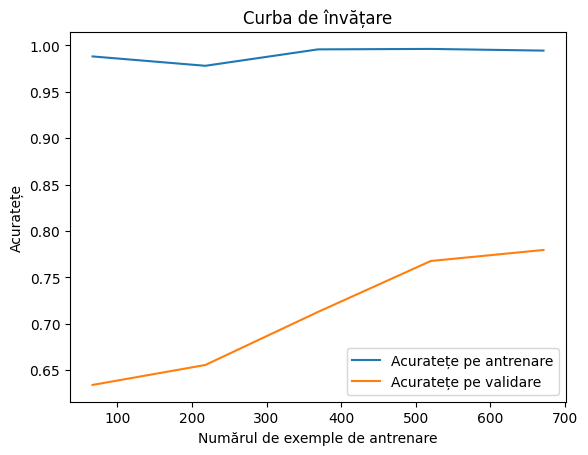

In [ ]:
# Afișăm curba de învățare
train_sizes, train_scores, val_scores = learning_curve(svm_model, X_train, y_train,
                                              cv=5, scoring='accuracy', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Acuratețe pe antrenare')
plt.plot(train_sizes, val_mean, label='Acuratețe pe validare')
plt.xlabel('Numărul de exemple de antrenare')
plt.ylabel('Acuratețe')
plt.title('Curba de învățare')
plt.legend()
plt.show()


In [ ]:
# Generăm rapoartele de clasificare
print("Raport de clasificare pe setul de validare:")
print(classification_report(y_val, y_val_pred, target_names=unique_labels))

print("Raport de clasificare pe setul de test:")
print(classification_report(y_test, y_test_pred, target_names=unique_labels))


Raport de clasificare pe setul de validare:
              precision    recall  f1-score   support

       scand       0.80      0.79      0.79        99
       tudor       0.81      0.82      0.82       111

    accuracy                           0.80       210
   macro avg       0.80      0.80      0.80       210
weighted avg       0.80      0.80      0.80       210

Raport de clasificare pe setul de test:
              precision    recall  f1-score   support

       scand       0.88      0.75      0.81        79
       tudor       0.76      0.89      0.82        70

    accuracy                           0.81       149
   macro avg       0.82      0.82      0.81       149
weighted avg       0.82      0.81      0.81       149



In [ ]:
# Afișăm timpul de antrenare și inferență
start = time.time()
svm_model.fit(X_train, y_train)
end = time.time()
print(f"Timpul de antrenare: {end - start:.2f} secunde")

start = time.time()
y_val_pred = svm_model.predict(X_val)
end = time.time()
print(f"Timpul de inferență pe setul de validare: {end - start:.2f} secunde")


Timpul de antrenare: 0.16 secunde
Timpul de inferență pe setul de validare: 0.03 secunde


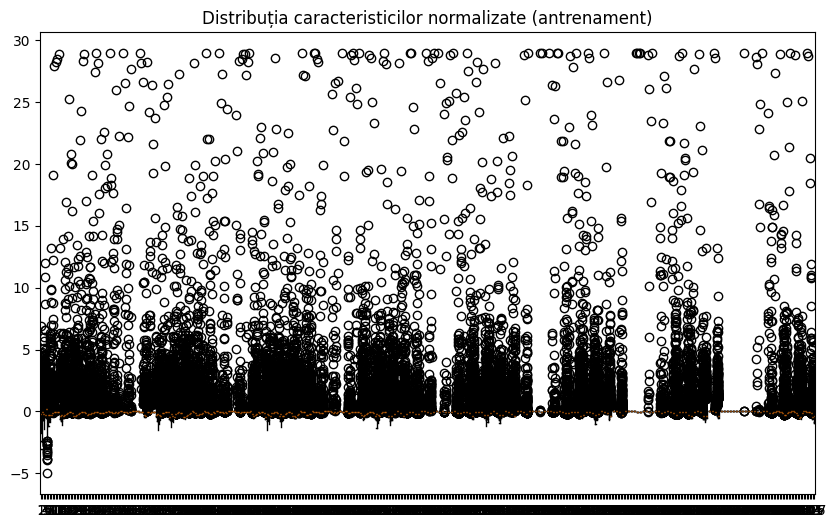

In [ ]:
# Verificăm dacă datele de intrare sunt bine distribuite sau dacă există anomalii
plt.figure(figsize=(10, 6))
plt.boxplot(X_train)
plt.title("Distribuția caracteristicilor normalizate (antrenament)")
plt.show()


In [ ]:
print(f"Număr de imagini în setul de antrenament: {len(X_train)}")
print(f"Număr de imagini în setul de validare: {len(X_val)}")

Număr de imagini în setul de antrenament: 839
Număr de imagini în setul de validare: 210


In [ ]:
def save_classified_images(images, true_labels, predicted_labels, save_dir):
    """
    Salvează imaginile clasificate într-un director specific, incluzând eticheta reală și predicția în numele fișierului.

    :param images: Lista de imagini (în format numpy array).
    :param true_labels: Lista etichetelor reale (string sau numeric).
    :param predicted_labels: Lista etichetelor prezise (string sau numeric).
    :param save_dir: Calea către directorul în care se vor salva imaginile.
    """
    # Creăm directorul dacă nu există
    os.makedirs(save_dir, exist_ok=True)

    for i, (image, true_label, pred_label) in enumerate(zip(images, true_labels, predicted_labels)):
        # Numele fișierului cu eticheta reală și predicția
        filename = f"image_{i+1}_true-{true_label}_pred-{pred_label}.png"
        filepath = os.path.join(save_dir, filename)

        # Salvăm imaginea
        cv2.imwrite(filepath, image)

    print(f"Imaginile clasificate au fost salvate în directorul: {save_dir}")


In [ ]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/rezultate_tema/rez_test'

# Imaginile din setul de testare
images_to_save = test_images

# Etichete reale și prezise (conversie numerică în text dacă este necesar)
true_labels = [index_to_label[y] for y in y_test]
predicted_labels = [index_to_label[y] for y in y_test_pred]

# Salvăm imaginile
save_classified_images(images_to_save, true_labels, predicted_labels, save_dir)


Imaginile clasificate au fost salvate în directorul: /content/drive/MyDrive/Colab Notebooks/rezultate_tema/rez_test


In [ ]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/rezultate_tema/rez_valid'

# Imaginile din setul de testare
images_to_save = X_val_images

# Etichete reale și prezise (conversie numerică în text dacă este necesar)
true_labels = [index_to_label[y] for y in y_val]
predicted_labels = [index_to_label[y] for y in y_val_pred]

# Salvăm imaginile
save_classified_images(images_to_save, true_labels, predicted_labels, save_dir)


Imaginile clasificate au fost salvate în directorul: /content/drive/MyDrive/Colab Notebooks/rezultate_tema/rez_valid
